# Starbucks Capstone Project

<img src="coffee.jpg"/>

### Content

1.  [Introduction](#introduction)  

2.  [Data Sets](#dataset)

3.  [Defining functions](#functions)

4.  [Data analysis, cleaning and transformation](#data_analysis)

5.  [Offers that really excite people](#offer_excite)

6.  [Data preparation for FunkSVD, training and prediction](#Model)

7.  [Conclusion](#conclusion)

<a id='introduction'> </a>
### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

The task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type.   because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

It is given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

It should be kept in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

**Example**

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

It should be taken into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Problem to be solved

I was curious if below questions/points could be addressed:

1. Do offers really play significant role in company's cash inflows?  
2. What kind of offers really excite people and bring more revenue?
3. General idea about people that tend to ignore offers comparing to responsive people.
4. How customer experience in terms of promo offers can be improved through personalization of the offers distribution using collaborative filtering technique (FunkSVD): where some group of mobile application users will receive certain offers based on their preferences and based on the preferences of customers with similar taste. 

From business perspective customers loyalty is generally increased when consumers got reward points they can use, so when selecting between Starbucks and any other competitor, Starbucks should be in a better position. In order to achieve that I have selected basic form of FunkSVD without regularization and within the notebook will verify if this choice was a good option. I would expect the model to perform better than a naive prediction - all customers are happy to receive and use offers. 

### Metrics and estimators

An estimator for FunkSVD function will be Mean Squared Error (MSE). MSE measures the average of the squares of the errors — that is the average squared difference between the estimated values and what is estimated. It shows how well squared difference decreases for all predictions with more gradient decent iterations. 
Accuracy was choosen as a metric for performance evaluation since both positive and negative reaction to offers are equally import to us: there is no big harm if we send an offer to a customer or if we refrain from doing that. The classes are not imbalanced (justified below). With all that in mind accuracy metric considered to be acceptable choice.  

<a id='dataset'> </a>

### Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record



In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline
import pandas as pd
import numpy as np
import math
import json
import pandasql as ps
from tqdm import tqdm_notebook as tqdm
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
sns.set()

from math import sqrt

In [14]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)
pd.set_option('display.max_columns', None)

<a id='functions'> </a>
#### Defining all necessary functions

In [15]:
#defining all necessary functions
def define_reward (value):
    """Data cleaning and preparation function. Returns reward amount from raw text line of value column in transcript dataframe.
    """
    line = str (value)
    if line [50:56] == 'reward':
        if line [-5] == ':':
            return int ((line [-3:-1]))
        else:     
            return int (line [-2])
    else: 
        return np.nan
    
def define_offer (value):
    """Data cleaning and preparation function. Returns offer id from raw text line of value column in transcript dataframe.
    """
    line = str (value)
    if line [2:7] == 'offer': 
        return line [14:46]
    else: 
        return np.nan
    
def define_amount (value):
    """Data cleaning and preparation function. Returns amount from raw text line of value column in transcript dataframe.
    """
    line = str (value)
    if line [2:8] == 'amount': 
        return round (float (line [11:-1]), 2)
    else: 
        return np.nan

def define_subtype (value):
    """Data cleaning and preparation function. Returns offer subtype when receive offer_id as value.
    """
    if portfolio [portfolio['id'] == value].shape[0] != 0:
        return np.array(portfolio [portfolio['id'] == value] ['subtype'])[0]
    else:
        return np.nan

def userid_mapper():
    """Function that prepares mapping between actual person iDs and the integer values. Returns both dictionary with 
    mapping and the list of encoded users.
    """
    coded_dict = dict()
    cter = 1
    userid_encoded = []
    
    for val in df['person']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        userid_encoded.append(coded_dict[val])
    return userid_encoded, coded_dict


def validation_func (test_matrix, predict_train_matrix, is_train =False, verbose=True):
    """Function that runs validation of predicted user item matrix (predict_train_matrix) on the given user item matrix 
    (test or train matrix). 
    
    INPUT: 
    Test user item matrix, predicted user item matrix, is_train sign (if validation done on train), verbose sign (whether to print results)
    OUTPUT: 
    MSE error value, Accuracy value. If verbose equals True then results just printed. Nothing returned.
       
    """
        
    #will be looping over common customers only
    test_idx = test_matrix.index.intersection (predict_train_matrix.index)
    test_cols = test_matrix.columns

    sse_accum = 0
    diff = 0
    acc = []

    for i in test_idx: 
        for j in test_cols: 
            if test_matrix.at [i,j]>=0:
                # compute the error as the actual minus the dot product of the user and offer latent features
                diff = test_matrix.at [i,j] - predict_train_matrix.at [i,j]
                        
                # Keep track of the sum of squared errors for the matrix
                sse_accum += diff**2
                acc.append (abs (diff))

    #deviding on the overall not null values in test_matrix
    mse_error = sse_accum/(test_matrix.notnull().sum ().sum())
    acc_test = 1 - sum (acc)/(test_matrix.notnull().sum ().sum())

    if (is_train == False)&(verbose): 
        print ('\n')
        print ('MSE on the test set is: ', mse_error)
        print ('RMSE on the test set is: ', sqrt(mse_error))
        print ('Accuracy on the test set is: ', acc_test)
        print ('\n')
    if (is_train == True)&(verbose): 
        print ('\n')
        print ('MSE on the train set is: ', mse_error)
        print ('RMSE on the train set is: ', sqrt(mse_error))
        print ('Accuracy on the train set is: ', acc_test)
        print ('\n')
    #if no need for printing just return values of MSE and Accuracy
    if verbose == False: 
        return mse_error, acc_test
    
def trans_affected_func (df): 
    """Function that takes transactions reflected in the original dataframe and marks those that were done 
    as a result of promo offers.  
    For transactions that were affected by any offer following fields filled: 
    'offer_id',
    'offer_type'
    INPUT: a df produced as a result of merging transcript, portfolio and profile.
    OUTPUT: a dataframe with the same structure with 'offer_id','offer_type' columns updated.
    """
    #slice subsets with offers received, viewed, completed and transactions
    offer_rec_df = df [df ['event'] =='offer received'].copy ()
    offer_view_df = df [df ['event'] =='offer viewed'].copy ()
    offer_compl_df = df [df ['event'] =='offer completed'].copy ()
    trans_df = df[df['event'] == 'transaction'].copy ()
    
    #adding a column with a date (in hours) when offer's affect is ending
    offer_rec_df ['offer_end_time'] = offer_rec_df ['time'] + offer_rec_df ['duration']*24 
    
    #firstly running through informational offers
    for i in tqdm (offer_view_df [offer_view_df['offer_type']=='informational'].index): 
    
        #saving parameters
        person = offer_view_df.at [i, 'person']
        offer_id = offer_view_df.at [i, 'offer_id']
        time_view = offer_view_df.at [i, 'time']
        
        #finding offers received by this person with the same offer id
        #taking only offers that were recieved before the offer view time
        #sorting by the time from the newest to the oldest
        offers_received = offer_rec_df [(offer_rec_df ['person'] == person)&\
                                        (offer_rec_df ['offer_id'] == offer_id) &\
                                        (offer_rec_df ['time'] <= time_view) & \
                                        (offer_rec_df ['offer_end_time'] >= time_view)].copy ().\
                                        sort_values (by = ['time'], ascending = False)
        
        #if no such offers were received by this person or viewed post the affect time then skip
        if offers_received.shape [0] == 0: 
            continue 
            
        offers_received.reset_index (drop = True, inplace = True)
            
        criteria =  (trans_df ['time'] >= offers_received.at [0, 'time']) &\
                    (trans_df ['time'] >= time_view)&\
                    (trans_df ['time'] <= offers_received.at [0, 'offer_end_time'])&\
                    (trans_df ['person'] == person)
        
        trans_df.at [criteria, 'offer_type'] =  'informational'   
        trans_df.at [criteria, 'offer_id'] = offer_id
            
    #now running through bogo and discount and if by chance a transaction happened within informational offer 
    #affect time and at the same time it was done so to complete discount or bogo and the completion happened
    #then we shall consider transaction affected by bogo or discount rather than informational 
    for i in tqdm (offer_view_df [offer_view_df['offer_type']!='informational'].index): 
    
        #saving parameters
        person = offer_view_df.at [i, 'person']
        offer_id = offer_view_df.at [i, 'offer_id']
        time_view = offer_view_df.at [i, 'time']
        
        #finding offers received by this person with the same offer id
        #taking only offers that were recieved before the offer view time
        #sorting by the time from the newest to the oldest
        offers_received = offer_rec_df [(offer_rec_df ['person'] == person)&\
                                        (offer_rec_df ['offer_id'] == offer_id) &\
                                        (offer_rec_df ['time'] <= time_view) & \
                                        (offer_rec_df ['offer_end_time'] >= time_view)].copy ().\
                                        sort_values (by = ['time'], ascending = False)
        
        #if no such offers were received by this person or viewed post the affect time then skip
        if offers_received.shape [0] == 0: 
            continue 
        
        #taking received offer that is the closest by time to the time of offer completed
        #in condition that there is a transaction between them
        #and checking if offer was completed within offer deadline
        
        offers_received.reset_index (drop = True, inplace = True)
        time_rec = offers_received.at [0, 'time']
        time_rec_end = offers_received.at [0, 'offer_end_time']
        
        #finding offers completed by this person with the same offer id
        #taking only offers that were completed before deadline
        #we will check transactions that were done to make offer completed. partial completion will not be taken
        #into consideration as we consider that if offer was not completed fully then it did not affect customer
        #sorting by the time so to fine closest completed offer
        offers_completed=offer_compl_df[(offer_compl_df ['person'] == person)&\
                                        (offer_compl_df ['offer_id'] == offer_id) &\
                                        (offer_compl_df ['time'] >= time_rec) & \
                                        (offer_compl_df ['time'] <= time_rec_end)&\
                                        (offer_compl_df ['time'] >= time_view)].copy ().\
                                        sort_values (by = ['time'], ascending = True)
        
        #if no such offers were completed by this person then we don't have transactions affected
        if offers_completed.shape [0] == 0: 
            continue 
        
        #reset index
        offers_completed.reset_index (drop = True, inplace = True)
        
        #criteria for the transactions to be marked as affected
        criteria = (trans_df ['time'] >= time_rec) &\
                   (trans_df ['time'] >= time_view)&\
                   (trans_df ['time'] <= time_rec_end)&\
                   (trans_df ['time'] <= offers_completed.at [0, 'time'])&\
                   (trans_df ['person'] == person)
        
        trans_df.at [criteria, 'offer_type'] =  offers_completed.at [0, 'offer_type']   
        trans_df.at [criteria, 'offer_id'] = offer_id
        
    return trans_df

#then check trans_affect and do similar but for informational. count only if transactions happened with informational subtype
def offer_inform_rate (): 
    """ Function that prepares preliminary dataframe out of which user_item_matrix will be formed for informational offers.
    The dataframe will contain 3 columns: 'user_id', 'rate','off_subtype_id'
    If particular user made a transaction affected by a particular informational offer at least once, then 
    a row added to the dataframe with userid, with rate equals 1 and offer subtype digital number as per subt_dict_inform 
    dictionary. If never made transactions affected by particular informational offer then a row added to the dataframe
    with userid, with rate equals 0 and offer subtype digital number. 
    
    INPUT: 
    trans_affect dataframe, a df produced as a result of merging transcript, portfolio and profile.
    OUTPUT:
    a dataframe that contains 3 columns: 'user_id', 'rate','off_subtype_id' with ratings for customers.
    """
    
    trans_inform = trans_affect [trans_affect ['offer_type'] =='informational'].copy ()
    trans_inform ['user_id'] = trans_inform ['person']
    trans_inform ['user_id'].replace (userid_dict, inplace = True)
    trans_inform ['subtype'] =trans_inform ['offer_subtype'] 
    trans_inform = trans_inform [['event', 'user_id', 'subtype']]
    
    df_inform = df [df ['offer_type'] == 'informational'].copy ()
    df_inform = df_inform [['event', 'user_id', 'subtype']]
    
    df_inform = pd.concat ([trans_inform, df_inform], ignore_index = True)
       
    #initializing empty dataframe that will be enriched with data
    df_rate = pd.DataFrame (columns = ['user_id', 'rate','off_subtype_id'])
    
    #loop over informational subtypes
    for subtype_id in subt_dict_inform: 
        
        #taking slice from trans_inform with specific subtype
        df_tmp = df_inform [df_inform ['subtype'] == subtype_id].copy ()
    
        #rate =1 if user completed offer else 0
        df_tmp ['rate'] = df_tmp ['event'].apply (lambda x: 1 if x == 'transaction' else 0)
        #grouping by user so that if a user at any time completed offer rate will be >0
        df_rate_tmp = pd.DataFrame (df_tmp.groupby ('user_id') ['rate'].sum ()).reset_index ()
        #saving offer subtype id
        df_rate_tmp ['off_subtype_id'] = subtype_dict [subtype_id]
    
        #we should count only 1 and 0. 1 if ever used 0 if never completed such offer 
        df_rate_tmp ['rate'] = df_rate_tmp ['rate'].apply (lambda x: 1 if x>0 else 0)
        
        #print (df_rate_tmp)
        df_rate = pd.concat ([df_rate, df_rate_tmp], ignore_index = True)
        
    return df_rate

def trans_affected_func (df): 
    """Function that takes transactions reflected in the original dataframe and marks those that were done 
    as a result of promo offers.  
    For transactions that were affected by any offer following fields filled: 
    'offer_id',
    'offer_type'
    INPUT: a df produced as a result of merging transcript, portfolio and profile.
    OUTPUT: a dataframe with the same structure with 'offer_id','offer_type' columns updated.
    """
    #slice subsets with offers received, viewed, completed and transactions
    offer_rec_df = df [df ['event'] =='offer received'].copy ()
    offer_view_df = df [df ['event'] =='offer viewed'].copy ()
    offer_compl_df = df [df ['event'] =='offer completed'].copy ()
    trans_df = df[df['event'] == 'transaction'].copy ()
    
    #adding a column with a date (in hours) when offer's affect is ending
    offer_rec_df ['offer_end_time'] = offer_rec_df ['time'] + offer_rec_df ['duration']*24 
    
    #firstly running through informational offers
    for i in tqdm (offer_view_df [offer_view_df['offer_type']=='informational'].index): 
    
        #saving parameters
        person = offer_view_df.at [i, 'person']
        offer_id = offer_view_df.at [i, 'offer_id']
        time_view = offer_view_df.at [i, 'time']
        
        #finding offers received by this person with the same offer id
        #taking only offers that were recieved before the offer view time
        #sorting by the time from the newest to the oldest
        offers_received = offer_rec_df [(offer_rec_df ['person'] == person)&\
                                        (offer_rec_df ['offer_id'] == offer_id) &\
                                        (offer_rec_df ['time'] <= time_view) & \
                                        (offer_rec_df ['offer_end_time'] >= time_view)].copy ().\
                                        sort_values (by = ['time'], ascending = False)
        
        #if no such offers were received by this person or viewed post the affect time then skip
        if offers_received.shape [0] == 0: 
            continue 
            
        offers_received.reset_index (drop = True, inplace = True)
            
        criteria =  (trans_df ['time'] >= offers_received.at [0, 'time']) &\
                    (trans_df ['time'] >= time_view)&\
                    (trans_df ['time'] <= offers_received.at [0, 'offer_end_time'])&\
                    (trans_df ['person'] == person)
        
        trans_df.at [criteria, 'offer_type'] =  'informational'   
        trans_df.at [criteria, 'offer_id'] = offer_id
            
    #now running through bogo and discount and if by chance a transaction happened within informational offer 
    #affect time and at the same time it was done so to complete discount or bogo and the completion happened
    #then we shall consider transaction affected by bogo or discount rather than informational 
    for i in tqdm (offer_view_df [offer_view_df['offer_type']!='informational'].index): 
    
        #saving parameters
        person = offer_view_df.at [i, 'person']
        offer_id = offer_view_df.at [i, 'offer_id']
        time_view = offer_view_df.at [i, 'time']
        
        #finding offers received by this person with the same offer id
        #taking only offers that were recieved before the offer view time
        #sorting by the time from the newest to the oldest
        offers_received = offer_rec_df [(offer_rec_df ['person'] == person)&\
                                        (offer_rec_df ['offer_id'] == offer_id) &\
                                        (offer_rec_df ['time'] <= time_view) & \
                                        (offer_rec_df ['offer_end_time'] >= time_view)].copy ().\
                                        sort_values (by = ['time'], ascending = False)
        
        #if no such offers were received by this person or viewed post the affect time then skip
        if offers_received.shape [0] == 0: 
            continue 
        
        #taking received offer that is the closest by time to the time of offer completed
        #in condition that there is a transaction between them
        #and checking if offer was completed within offer deadline
        
        offers_received.reset_index (drop = True, inplace = True)
        time_rec = offers_received.at [0, 'time']
        time_rec_end = offers_received.at [0, 'offer_end_time']
        
        #finding offers completed by this person with the same offer id
        #taking only offers that were completed before deadline
        #we will check transactions that were done to make offer completed. partial completion will not be taken
        #into consideration as we consider that if offer was not completed fully then it did not affect customer
        #sorting by the time so to fine closest completed offer
        offers_completed=offer_compl_df[(offer_compl_df ['person'] == person)&\
                                        (offer_compl_df ['offer_id'] == offer_id) &\
                                        (offer_compl_df ['time'] >= time_rec) & \
                                        (offer_compl_df ['time'] <= time_rec_end)&\
                                        (offer_compl_df ['time'] >= time_view)].copy ().\
                                        sort_values (by = ['time'], ascending = True)
        
        #if no such offers were completed by this person then we don't have transactions affected
        if offers_completed.shape [0] == 0: 
            continue 
        
        #reset index
        offers_completed.reset_index (drop = True, inplace = True)
        
        #criteria for the transactions to be marked as affected
        criteria = (trans_df ['time'] >= time_rec) &\
                   (trans_df ['time'] >= time_view)&\
                   (trans_df ['time'] <= time_rec_end)&\
                   (trans_df ['time'] <= offers_completed.at [0, 'time'])&\
                   (trans_df ['person'] == person)
        
        trans_df.at [criteria, 'offer_type'] =  offers_completed.at [0, 'offer_type']   
        trans_df.at [criteria, 'offer_id'] = offer_id
        
    return trans_df

#then check trans_affect and do similar but for informational. count only if transactions happened with informational subtype
def offer_inform_rate (): 
    """ Function that prepares preliminary dataframe out of which user_item_matrix will be formed for informational offers.
    The dataframe will contain 3 columns: 'user_id', 'rate','off_subtype_id'
    If particular user made a transaction affected by a particular informational offer at least once, then 
    a row added to the dataframe with userid, with rate equals 1 and offer subtype digital number as per subt_dict_inform 
    dictionary. If never made transactions affected by particular informational offer then a row added to the dataframe
    with userid, with rate equals 0 and offer subtype digital number. 
    
    INPUT: 
    trans_affect dataframe, a df produced as a result of merging transcript, portfolio and profile.
    OUTPUT:
    a dataframe that contains 3 columns: 'user_id', 'rate','off_subtype_id' with ratings for customers.
    """
    
    trans_inform = trans_affect [trans_affect ['offer_type'] =='informational'].copy ()
    trans_inform ['user_id'] = trans_inform ['person']
    trans_inform ['user_id'].replace (userid_dict, inplace = True)
    trans_inform ['subtype'] =trans_inform ['offer_subtype'] 
    trans_inform = trans_inform [['event', 'user_id', 'subtype']]
    
    df_inform = df [df ['offer_type'] == 'informational'].copy ()
    df_inform = df_inform [['event', 'user_id', 'subtype']]
    
    df_inform = pd.concat ([trans_inform, df_inform], ignore_index = True)
       
    #initializing empty dataframe that will be enriched with data
    df_rate = pd.DataFrame (columns = ['user_id', 'rate','off_subtype_id'])
    
    #loop over informational subtypes
    for subtype_id in subt_dict_inform: 
        
        #taking slice from trans_inform with specific subtype
        df_tmp = df_inform [df_inform ['subtype'] == subtype_id].copy ()
    
        #rate =1 if user completed offer else 0
        df_tmp ['rate'] = df_tmp ['event'].apply (lambda x: 1 if x == 'transaction' else 0)
        #grouping by user so that if a user at any time completed offer rate will be >0
        df_rate_tmp = pd.DataFrame (df_tmp.groupby ('user_id') ['rate'].sum ()).reset_index ()
        #saving offer subtype id
        df_rate_tmp ['off_subtype_id'] = subtype_dict [subtype_id]
    
        #we should count only 1 and 0. 1 if ever used 0 if never completed such offer 
        df_rate_tmp ['rate'] = df_rate_tmp ['rate'].apply (lambda x: 1 if x>0 else 0)
        
        #print (df_rate_tmp)
        df_rate = pd.concat ([df_rate, df_rate_tmp], ignore_index = True)
        
    return df_rate

def offer_rate (): 
    """Function that prepares preliminary dataframe out of which user_item_matrix will be formed
    The dataframe will contain 3 columns: 'user_id', 'rate','off_subtype_id'
    If particular user completed particular offer at least once, then 
    a row added to the dataframe with userid, with rate equals 1 and offer subtype digital number as per subt_dict_bogo_disc 
    dictionary. If never completed any offer then a row added to the dataframe with userid, with rate equals 0 and 
    offer subtype digital number. 
    
    INPUT: 
    a df produced as a result of merging transcript, portfolio and profile.
    OUTPUT:
    a dataframe that contains 3 columns: 'user_id', 'rate','off_subtype_id' with ratings for customers.
    """
    #initializing empty dataframe that will be enriched with data
    df_rate = pd.DataFrame (columns = ['user_id', 'rate','off_subtype_id'])
    
    #loop over subtypes (except informational)
    for subtype_id in subt_dict_bogo_disc: 
        
        #taking slice from df for specific subtype
        df_tmp = df [df ['subtype'] == subtype_id].copy ()
    
        #rate =1 if user completed offer else 0
        df_tmp ['rate'] = df_tmp ['event'].apply (lambda x: 1 if x == 'offer completed' else 0)
        
        #grouping by user so that if a user at any time completed offer rate will be >0
        df_rate_tmp = pd.DataFrame (df_tmp.groupby ('user_id') ['rate'].sum ()).reset_index ()
        
        #saving offer subtype id
        df_rate_tmp ['off_subtype_id'] = subtype_dict [subtype_id]
    
        #we should count only 1 and 0. 1 if ever used 0 if never completed such offer 
        df_rate_tmp ['rate'] = df_rate_tmp ['rate'].apply (lambda x: 1 if x>0 else 0)
        
        df_rate = pd.concat ([df_rate, df_rate_tmp], ignore_index = True)
        
    return df_rate

#defining function to compare customers affected by offers and those who are not 
def comparison_func (df1, df2, column):
    """Plot two subplots from df1 and df2 for the values of column
    """
    
    fig, ax =plt.subplots(1,2)
    sns.countplot(df1[column], ax=ax[0])
    sns.countplot(df2[column], ax=ax[1])
    plt.subplots_adjust(wspace= 0.5)
    fig.show()
    return 

def FunkSVD(ratings_mat, latent_features=4, learning_rate=0.0001, iters=100, random_seed=52, verbose=True):
    '''This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    ratings_mat - (numpy array) a matrix with users as rows, offers (subtype) as columns, and ratings as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    offer_mat - (numpy array) a latent feature by offer matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_users = ratings_mat.shape[0]
    n_offers = ratings_mat.shape[1]
    num_ratings = np.count_nonzero(~np.isnan(ratings_mat))
    
    # initialize the user and offer matrices with random values
    np.random.seed (random_seed)
    user_mat = np.random.rand(n_users, latent_features)
    offer_mat = np.random.rand(latent_features, n_offers)
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # header for running results
    if verbose:
        print("Optimizaiton Statistics")
        print("Iterations | Mean Squared Error ")
    
    # for each iteration
    for iteration in range(iters):

        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        # For each user-offer pair
        for i in range(n_users):
            for j in range(n_offers):
                
                # if the rating exists
                if (ratings_mat[i, j] == 0)|(ratings_mat[i, j] == 1):
                    
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = ratings_mat[i, j] - np.dot(user_mat[i, :], offer_mat[:, j])
                    
                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
                    
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_mat[i, k] += learning_rate * (2*diff*offer_mat[k, j])
                        offer_mat[k, j] += learning_rate * (2*diff*user_mat[i, k])

        # print results for iteration
        if verbose: 
            print("%d \t\t %f" % (iteration+1, sse_accum / num_ratings))
    
    return user_mat, offer_mat 

def user_item_train_test_split (df_rate_joint, test_size=0.1, random_seed = 22):
    """Function that prepares train and test user_item_matrices out of df_rate_joint.
    
    INPUT: 
    1.  dataframe with rates, should including following columns: user_id, rate, off_subtype_id 
    2.  test_size, default = 0.1
    3.  random_seed, default = 22
    OUTPUT:
    1.  train user_item_matrix
    2.  test user_item_matrix
        
    """
    
    #saving a df to work with
    rate_df = df_rate_joint.copy ()
    
    #taking part of ratings 
    test_tmp = rate_df.sample(frac =test_size, random_state =random_seed)
    
    #eliminating taken data from rate_df so to form train
    train_tmp = rate_df.drop (index = test_tmp.index)
    
    #converting both into user_item format
    train_matrix = train_tmp.groupby(['user_id', 'off_subtype_id'])['rate'].sum ().unstack()
    test_matrix = test_tmp.groupby(['user_id', 'off_subtype_id'])['rate'].sum ().unstack()
    
    return train_matrix, test_matrix  

def gridsearch_funkSVD (parameters): 
    """Function that verifies MSE, accuracy on train and test sets for all given possible parameters of FunkSVD. 
    Results appened to a dataframe which printed on the screen.
       
    INPUT: 
    FunkSVD parameters
    OUTPUT: 
    dataframe printed on the screen with following columns: 
    'num_latent_feat','learning_rate', 'number_of_iter','mse_on_train','acc_on_train','mse_on_test', 'acc_on_test',
    'overfitting'.
        
    Column overfitting is filled with 'Yes' whenever number of predicted values for any column (subtype) is more than 2 (0 or 1), 
    which is a clear signal that model is overfitting on the train set.
        
    """
    #saving parameters
    latent_feat_list = parameters ['latent_feat']
    num_iter_list = parameters ['num_iter']
    lrn_list = parameters ['learning_rate']
        
    results_df = pd.DataFrame ([], columns = ['num_latent_feat','learning_rate',\
                                                  'number_of_iter','mse_on_train','acc_on_train',\
                                                  'mse_on_test', 'acc_on_test', 'overfitting'])
    #looping through all possible parameters    
    for lat_feat in tqdm(latent_feat_list):
        for num_iter in tqdm(num_iter_list):
            for lrn_rate in tqdm (lrn_list):
                model_overfit = 'No'
                user_mat_train, offer_mat_train = FunkSVD (np.matrix (train_matrix), latent_features=lat_feat,\
                                                           learning_rate=lrn_rate, iters=num_iter, verbose=False)
                train_predict_np= np.abs(np.round (np.dot(user_mat_train, offer_mat_train)))

                #checking predicted values in each column
                predict_train_matrix = pd.DataFrame (train_predict_np, index = train_matrix.index, columns = train_matrix.columns)
                for j in predict_train_matrix.columns:
                    if predict_train_matrix[j].nunique()>2:
                        model_overfit = 'Yes'
                        #no need to check other columns
                        break
    
                train_mse, train_acc= validation_func (train_matrix, predict_train_matrix, is_train=True, verbose=False)
                test_mse, test_acc= validation_func (test_matrix, predict_train_matrix, verbose=False)
                    
                results_df.loc[-1] = [lat_feat, lrn_rate,num_iter,train_mse,train_acc,test_mse,test_acc,model_overfit]
                results_df.index =results_df.index+1
                results_df.sort_index ()
    display (results_df.reset_index())


<a id='data_analysis'> </a>
### Data analysis, cleaning and transfromation

In [16]:
#review portfolio dataframe
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [17]:
#adding column into portfolio that will define subtype used for further analysis
portfolio ['subtype'] = portfolio['offer_type']+ '_'+portfolio['duration'].map (str)+'_'+portfolio['difficulty'].map(str)

In [18]:
portfolio.shape 

(10, 7)

In [19]:
#possible offer types
portfolio ['offer_type'].unique()

array(['bogo', 'informational', 'discount'], dtype=object)

**Review of profile dataset**

In [20]:
profile.head (n=10)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


In [21]:
profile.shape

(17000, 5)

In [22]:
#missing values
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [23]:
#converting "became_member_on" into a date format  
profile ['became_member_on'] = pd.to_datetime (profile ['became_member_on'], format = '%Y%m%d', errors = 'coerce')

In [24]:
#preparing data to review subscription timeline trends
subscrip_df = profile.groupby(['became_member_on'], as_index=False).agg({'id':'count'})
subscrip_df.set_index ('became_member_on', inplace = True)
subscrip_Y_df = subscrip_df['id'].resample('Y').sum ()
subscrip_M_df = subscrip_df['id'].resample('M').sum ()
subscrip_D_df = subscrip_df['id'].resample('D').sum ()

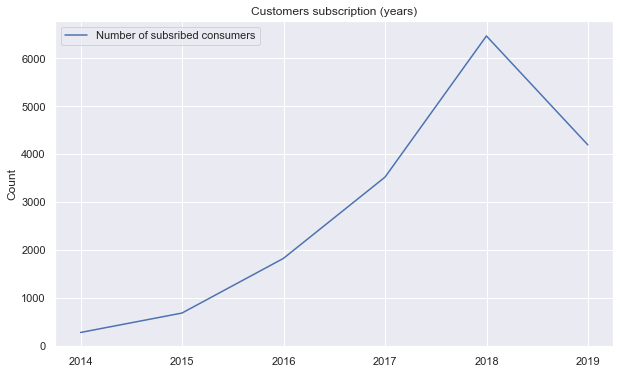

In [25]:
#Years subscription
x = subscrip_Y_df.index
fig, ax = plt.subplots(figsize = (10,6))
y1 = subscrip_Y_df 
ax.set_ylabel('Count')
ax.plot(x, y1, label = 'Number of subsribed consumers')
ax.set_title("Customers subscription (years)")
plt.legend (loc = 'best')
plt.show()

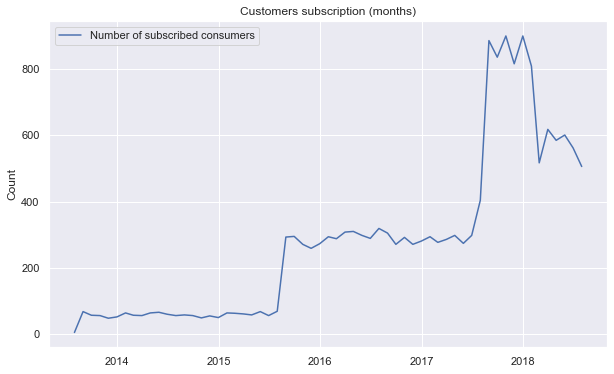

In [26]:
#Months subscription
x = subscrip_M_df.index
fig, ax = plt.subplots(figsize = (10,6))
y1 = subscrip_M_df 
ax.set_ylabel('Count')
ax.plot(x, y1, label = 'Number of subscribed consumers')
ax.set_title("Customers subscription (months)")
plt.legend (loc = 'best')
plt.show()

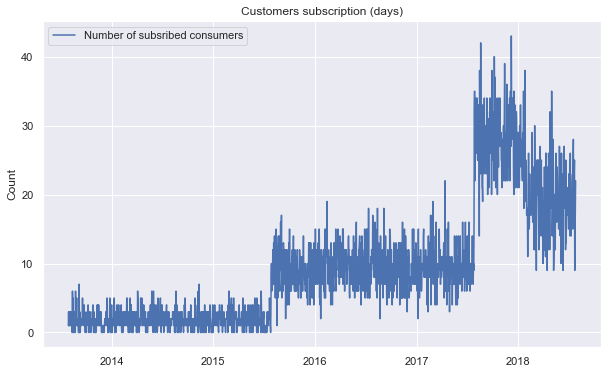

In [27]:
#subscription in days
x = subscrip_D_df.index
fig, ax = plt.subplots(figsize = (10,6))
y1 = subscrip_D_df 
ax.set_ylabel('Count')
ax.plot(x, y1, label = 'Number of subsribed consumers')
ax.set_title("Customers subscription (days)")
plt.legend (loc = 'best')
plt.show()

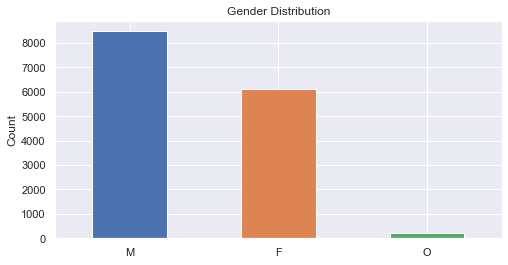

In [28]:
#plotting gender distribution 
fig, ax = plt.subplots(figsize = (8,4))
profile.gender.value_counts().plot(kind='bar', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_title('Gender Distribution')
ax.set_ylabel('Count')
plt.show ()

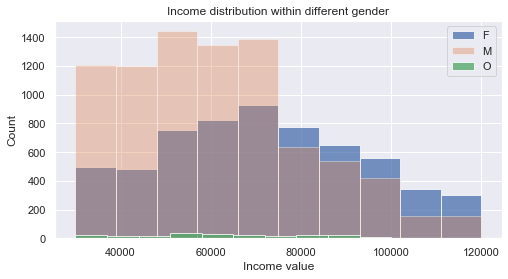

In [29]:
# plot income distribution histogram
fig, ax = plt.subplots(figsize = (8,4))

ax.hist(profile[profile.gender == 'F']['income'], alpha=0.76, label='F')
ax.hist(profile[profile.gender == 'M']['income'], alpha=0.37, label='M')
ax.hist(profile[profile.gender == 'O']['income'], alpha=0.78, label='O')
ax.set_xlabel('Income value')
ax.set_ylabel('Count')
ax.set_title('Income distribution within different gender')
ax.legend()
plt.show ()

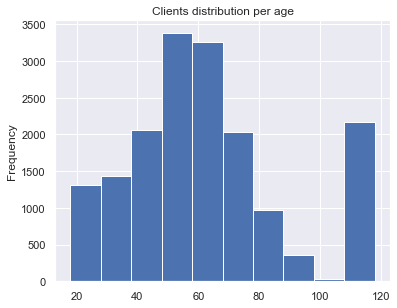

In [30]:
#plotting customers distribution by age
profile ['age'].plot (kind = 'hist',
                    title = 'Clients distribution per age',
                    figsize = (6, 4.8)
                      )

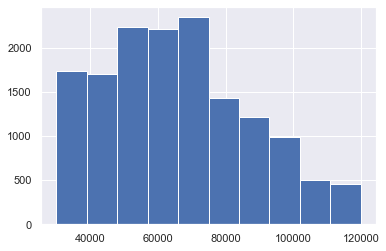

In [31]:
#verifying income distribution. 
profile ['income'].hist ();

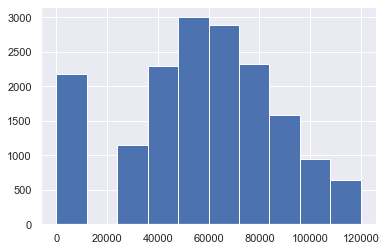

In [32]:
#As long as for income, for non-missing values nobody has income of zero 
#then let's fill NaNs for income with zeros and check how this affects the diagram

#saving for future below use
profile_income = profile.copy ()

#let's make a temp copy of profile data so to check missing values
profile_tmp = profile.copy ()
profile_tmp ['income'].fillna (0, inplace =True)
#let's mark missing gender as special - 'S'
profile_tmp ['gender'].fillna ('S', inplace =True)


profile_tmp ['income'].hist ();

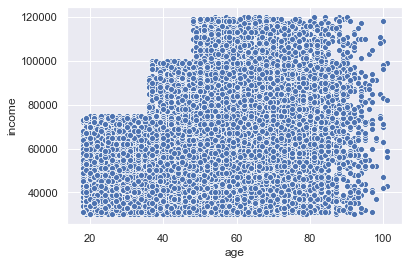

In [33]:
#scatter plot for age and income distribution
ax = sns.scatterplot (x = 'age', y= 'income', data = profile)
plt.show ()

Strict borders on the left and top side of the diagram above indicate artificial nature of the data where apparently there are income limits set for each age range.

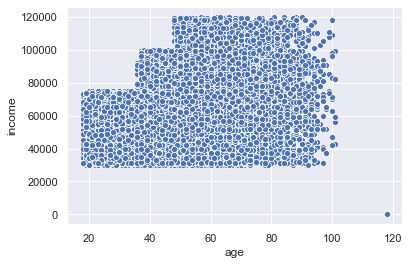

In [34]:
ax = sns.scatterplot (x='age', y='income', data = profile_tmp)

We can see that for people of age 118 we don't have actual income figures. Kind of **special group** of customers.

(2175, 5)
(2175, 5)


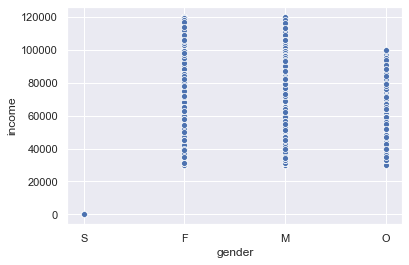

In [35]:
#let's check out deeply if customers with missing values for gender are the same 
#customers with income missing 
print (profile_tmp [profile_tmp ['income'] == 0].shape)
print (profile_tmp [profile_tmp ['gender'] == 'S'].shape)
ax = sns.scatterplot (x= 'gender', y='income', data = profile_tmp)

From the diagram we can see that with missing gender are exactly the same with missing income

In [36]:
print (profile_tmp [profile_tmp ['income'] == 0].head (n=3))

   age became_member_on gender                                id  income
0  118       2017-02-12      S  68be06ca386d4c31939f3a4f0e3dd783     0.0
2  118       2018-07-12      S  38fe809add3b4fcf9315a9694bb96ff5     0.0
4  118       2017-08-04      S  a03223e636434f42ac4c3df47e8bac43     0.0


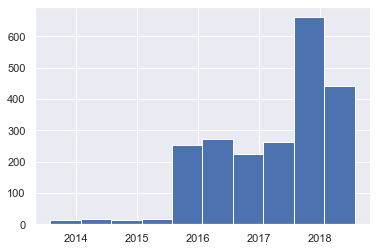

In [37]:
profile_tmp [profile_tmp ['income'] == 0] ['became_member_on'].hist();

In [38]:
#checking if in the datset we have people at age 118 but at the same time not in the special group
print ('Number of customers that have indicated income but at the same time they are at age 118: ', \
       profile_tmp [(profile_tmp ['income'] != 0)& (profile_tmp ['age'] == 118)].shape [0])

Number of customers that have indicated income but at the same time they are at age 118:  0


**Observations for the profile dataset**  
From the above we can see that customers with missing values for gender are the same customers with income missing. 
They form a special group of customers. People with age 118 presented ***only*** in this group.  
Subscription for them mostly done from 2016 onwards while in 2014 and 2015 only few of them subscribed.
*****
As a result of above analysis it appears that we may fullfill missing values in gender as 'S' and missing values in income with zeroes as it will not interfere with other group of customers.

In [39]:
#copying 
profile = profile_tmp.copy ()
profile.head (n=5)

,age,became_member_on,gender,id,income
0,118,2017-02-12,S,68be06ca386d4c31939f3a4f0e3dd783,0.0
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,2018-07-12,S,38fe809add3b4fcf9315a9694bb96ff5,0.0
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,2017-08-04,S,a03223e636434f42ac4c3df47e8bac43,0.0


Now let's verify if all the missing values eliminated

In [40]:
#number of missing values. 
profile.isnull ().sum ()

age                 0
became_member_on    0
gender              0
id                  0
income              0
dtype: int64

In [41]:
#now unique values for gender
profile['gender'].unique ()

array(['S', 'F', 'M', 'O'], dtype=object)

**Transcript dataset overview**

In [42]:
#now let's verify transcript
transcript.head (n=5)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [43]:
#unique values of event
transcript ['event'].unique ()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [44]:
transcript.shape

(306534, 4)

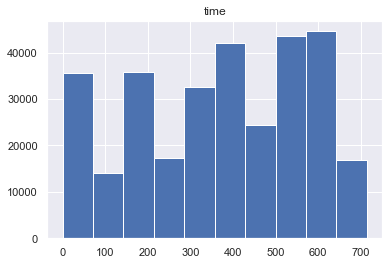

In [45]:
transcript.hist ();

In [46]:
#number of missing values
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

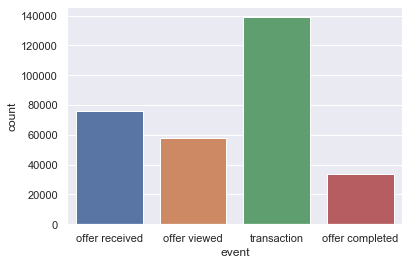

In [47]:
#checking distribution of events in the dataframe
sns.countplot('event', data= transcript)

Adding 3 new columns (offer_id, amount and reward_received) that will be filled out from value column. 

In [48]:
#adding new columns to transcript
transcript = transcript.join (pd.DataFrame ( { 'offer_id': np.nan, 'amount': np.nan,\
                                               'reward_received': np.nan}, index = transcript.index))

In [49]:
#data cleaning. we need to extract reward, offer_id and amount from raw test in value column
transcript ['reward_received'] = transcript ['value'].apply (define_reward)
transcript ['offer_id'] = transcript ['value'].apply (define_offer)
transcript ['amount'] = transcript ['value'].apply (define_amount)
transcript.isnull ().sum ()

event                   0
person                  0
time                    0
value                   0
offer_id           138953
amount             167581
reward_received    272955
dtype: int64

In [50]:
#review results
transcript .head (n=5)

,event,person,time,value,offer_id,amount,reward_received
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [51]:
transcript['amount'].describe()

count    138953.000000
mean         12.777356
std          30.250529
min           0.050000
25%           2.780000
50%           8.890000
75%          18.070000
max        1062.280000
Name: amount, dtype: float64

Text(0.5, 1.0, 'Ditribution of frequency of the overall amount spent by consumers')

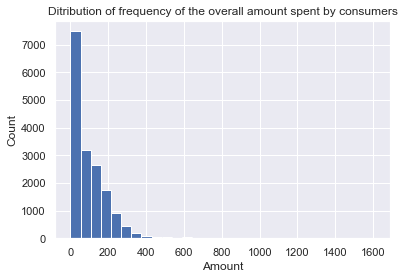

In [52]:
transcript.groupby('person')['amount']. sum ().hist(bins=30)
plt.xlabel('Amount')
plt.ylabel('Count')
plt.title('Ditribution of frequency of the overall amount spent by consumers')

Text(0.5, 1.0, 'Ditribution of mean of the amount spent by consumers')

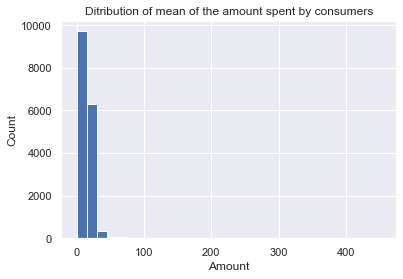

In [53]:
transcript.groupby('person')['amount'].mean().hist(bins=30)
plt.xlabel('Amount')
plt.ylabel('Count')
plt.title('Ditribution of mean of the amount spent by consumers')

From the above we can see that majority of transactions were done for small amounts, mean value 12.7 and for 75% of transactions amount was not greater than 18.07

In [54]:
print ('transcript shape: ', transcript.shape) 
print ('Number of unique customers in transcript: ', transcript ['person'].nunique ())
print ('Number of unique customers in profile: ', profile ['id'].nunique ())

transcript shape:  (306534, 7)
Number of unique customers in transcript:  17000
Number of unique customers in profile:  17000


In [55]:
unique_cust_profile = set (profile ['id'].unique ())
unique_cust_transcript = set (transcript ['person'].unique ())
len (unique_cust_profile.intersection (unique_cust_transcript))

17000

We can conclude that all the customers from transcript have corresponding data in profile.

In [56]:
#combining transcript and portfolio
df = transcript.merge (portfolio, left_on= 'offer_id', right_on= 'id', how= 'left', validate= 'many_to_one')

#dropping unnessary columns
df.drop (columns = ['value', 'id'], inplace = True)

#adding a column with time in days
df ['time_days'] = (df ['time']/24).round (decimals = 2)

df.head (n=5)

,event,person,time,offer_id,amount,reward_received,channels,difficulty,duration,offer_type,reward,subtype,time_days
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,"[web, email, mobile]",5.0,7.0,bogo,5.0,bogo_7_5,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,"[web, email]",20.0,10.0,discount,5.0,discount_10_20,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,"[web, email, mobile]",10.0,7.0,discount,2.0,discount_7_10,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,"[web, email, mobile, social]",10.0,10.0,discount,2.0,discount_10_10,0.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,"[web, email, mobile, social]",10.0,5.0,bogo,10.0,bogo_5_10,0.0


In [57]:
df [(df ['reward_received'] >0) & (df ['event'] != 'offer completed')] 

,event,person,time,offer_id,amount,reward_received,channels,difficulty,duration,offer_type,reward,subtype,time_days


Which means that rewards can be gained only when offer completed.

In [58]:
#merging with profile df
df = df.merge (profile, left_on = 'person', right_on = 'id', how = 'left', validate= 'many_to_one')

#dropping unnessary column
df.drop (columns = ['id'], inplace = True)
df.head (n=5)

,event,person,time,offer_id,amount,reward_received,channels,difficulty,duration,offer_type,reward,subtype,time_days,age,became_member_on,gender,income
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,"[web, email, mobile]",5.0,7.0,bogo,5.0,bogo_7_5,0.0,75,2017-05-09,F,100000.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,"[web, email]",20.0,10.0,discount,5.0,discount_10_20,0.0,118,2017-08-04,S,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,"[web, email, mobile]",10.0,7.0,discount,2.0,discount_7_10,0.0,68,2018-04-26,M,70000.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,"[web, email, mobile, social]",10.0,10.0,discount,2.0,discount_10_10,0.0,118,2017-09-25,S,0.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,"[web, email, mobile, social]",10.0,5.0,bogo,10.0,bogo_5_10,0.0,118,2017-10-02,S,0.0


In [59]:
print ('Number of customers that received an offer at least once ', df [df ['event'] == 'offer received'] ['person'].nunique ())
print ('Conclusion: 6 persons never recieved any offer but performed transactions')

Number of customers that received an offer at least once  16994
Conclusion: 6 persons never recieved any offer but performed transactions


In [60]:
print (df [(df ['event'] == 'offer completed') & (df ['reward_received'] != df ['reward'])].shape)
print (df [(df ['event'] == 'offer completed') & (df ['offer_type'] == 'informational')].shape)

(0, 17)
(0, 17)


Which means that whenever an offer completed reward recieved in full and at the same time there are no offer completed transactions for informational offers.

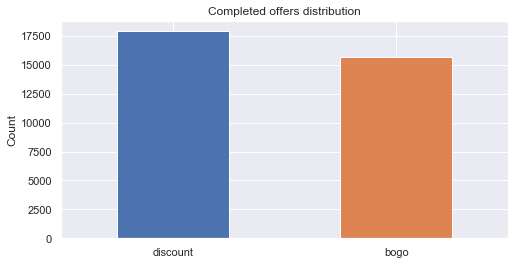

In [61]:
#let's visualize distribution of offer type within completed offers
offers_completed = df[df ['event'] == 'offer completed']

#plotting gender distribution 
fig, ax = plt.subplots(figsize = (8,4))
offers_completed.offer_type.value_counts().plot(kind='bar', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_title('Completed offers distribution')
ax.set_ylabel('Count')
plt.show ()

As we can see no entry for informational offers presented within completed offers.

#### Data transformation so to find transactions influenced by offers 

**Tricky case with data cleaning for affected transactions and the way it can be solved**  
It appears that a person may receive different offers simulatenesly, both offers can be viewed by a customer and if a transaction will happen when both offers were viewed and within timeline of them, then we should decide which offer actually led to the transaction.  As there is no clear direction from the dataset or background info I have assummed that the latest offer, closest in time to the transaction would be counted as an offer affected the transaction. In case one of the offers is informational and the second one gives reward then rewarding offer should prevail as I have assummed that customers would be more attracted by rewards as informational offers are not giving any additional benefits. 


In [62]:
#Example of such case 
df [df ['person'] == '24115a61df25473e84a8a03f3c98de1a'].tail (n=10)

,event,person,time,offer_id,amount,reward_received,channels,difficulty,duration,offer_type,reward,subtype,time_days,age,became_member_on,gender,income
207877,offer received,24115a61df25473e84a8a03f3c98de1a,504,ae264e3637204a6fb9bb56bc8210ddfd,NaN,NaN,"[email, mobile, social]",10.0,7.0,bogo,10.0,bogo_7_10,21.00,54,2018-05-23,M,39000.0
243312,offer viewed,24115a61df25473e84a8a03f3c98de1a,570,ae264e3637204a6fb9bb56bc8210ddfd,NaN,NaN,"[email, mobile, social]",10.0,7.0,bogo,10.0,bogo_7_10,23.75,54,2018-05-23,M,39000.0
251425,offer received,24115a61df25473e84a8a03f3c98de1a,576,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,"[web, email, mobile, social]",10.0,10.0,discount,2.0,discount_10_10,24.00,54,2018-05-23,M,39000.0
265770,transaction,24115a61df25473e84a8a03f3c98de1a,588,NaN,8.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.50,54,2018-05-23,M,39000.0
274653,offer viewed,24115a61df25473e84a8a03f3c98de1a,606,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,"[web, email, mobile, social]",10.0,10.0,discount,2.0,discount_10_10,25.25,54,2018-05-23,M,39000.0
274654,transaction,24115a61df25473e84a8a03f3c98de1a,606,NaN,14.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.25,54,2018-05-23,M,39000.0
274655,offer completed,24115a61df25473e84a8a03f3c98de1a,606,ae264e3637204a6fb9bb56bc8210ddfd,NaN,10.0,"[email, mobile, social]",10.0,7.0,bogo,10.0,bogo_7_10,25.25,54,2018-05-23,M,39000.0
274656,offer completed,24115a61df25473e84a8a03f3c98de1a,606,fafdcd668e3743c1bb461111dcafc2a4,NaN,2.0,"[web, email, mobile, social]",10.0,10.0,discount,2.0,discount_10_10,25.25,54,2018-05-23,M,39000.0
284056,transaction,24115a61df25473e84a8a03f3c98de1a,630,NaN,6.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.25,54,2018-05-23,M,39000.0
301979,transaction,24115a61df25473e84a8a03f3c98de1a,696,NaN,11.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.00,54,2018-05-23,M,39000.0


****
Function takes about an hour to complete running through all the viewed offers.

In [63]:
trans_affected = trans_affected_func (df)
#trans_affected.to_csv ('trans_aff.csv')

In [68]:
trans_affect = trans_affected
#trans_affect = pd.read_csv ('trans_aff.csv')
#trans_affect.set_index (keys = 'Unnamed: 0', drop = True, inplace = True)

Investigating **special group of customers marked as 'S'** gender above.

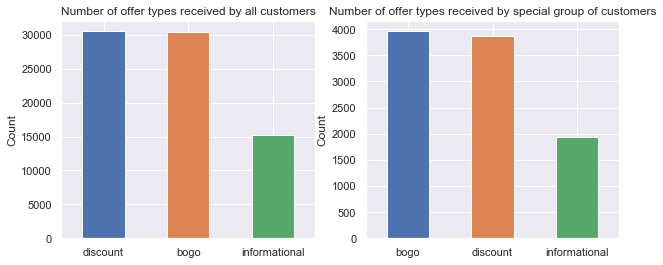

In [69]:
#plotting offer distribution 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (10,4))
ax1=axes[0]
ax2=axes[1]
df [df ['event'] =='offer received'].offer_type.value_counts().plot(kind='bar', ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax1.set_title('Number of offer types received by all customers')
ax1.set_ylabel('Count')

df [(df ['event'] =='offer received')&(df ['gender'] =='S')].offer_type.value_counts().plot(kind='bar', ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.set_title('Number of offer types received by special group of customers')
ax2.set_ylabel('Count')

plt.show ()

The proportions are looking similar. It means that that the algorithm sends offers without distinguishing this group.

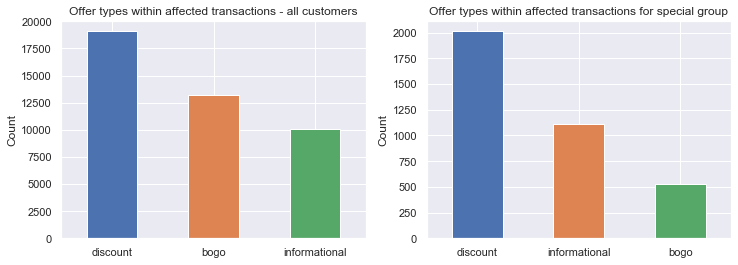

In [70]:
#let's visualize distribution of offer types that affected transactions

#plotting offer distribution 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (12,4))
ax1=axes[0]
ax2=axes[1]
trans_affect.offer_type.value_counts().plot(kind='bar', ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax1.set_title('Offer types within affected transactions - all customers')
ax1.set_ylabel('Count')

trans_affect [trans_affect ['gender']=='S'].offer_type.value_counts().plot(kind='bar', ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.set_title('Offer types within affected transactions for special group')
ax2.set_ylabel('Count')

plt.show ()


When it comes to the transactions, it appears that special group is more affected by informational offers rather than bogo comparing to the overall population. Discount offers on the first place for both of them.

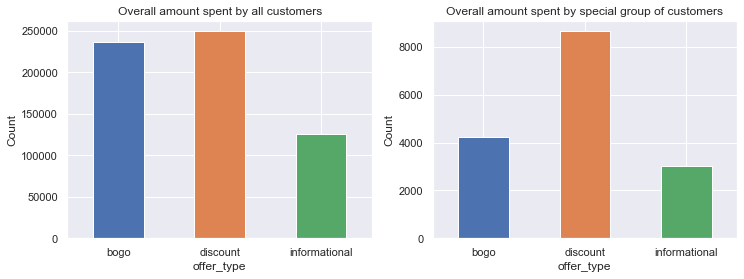

In [71]:
#let's verify amount spent by consumers within each offer type. 

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (12,4))
ax1=axes[0]
ax2=axes[1]

trans_affect.groupby('offer_type')['amount'].sum().plot(kind='bar', ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax1.set_title('Overall amount spent by all customers')
ax1.set_ylabel('Count')

trans_affect [trans_affect ['gender']=='S'].groupby('offer_type')['amount'].sum().plot(kind='bar', ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.set_title('Overall amount spent by special group of customers')
ax2.set_ylabel('Count')

plt.show ()

In [72]:
trans_affect.groupby('offer_type')['amount']. sum ()

offer_type
bogo             236669.26
discount         249679.39
informational    125797.34
Name: amount, dtype: float64

Amount spent is different for special group, this can be explained by the fact of bogo less popularity for S group, less number of transactions and less money spent. What is intresting here is that although number of transactions for bogo is noticeably lower than discount, the overall amount for bogo and discount are pretty close to each other. Details for amount consumed for each subtype within offers can be found below. 

#### Conclusion for special group. 

What we can see from above diagrams is that this special group differs in behavior from the general customers community. They are more instrested in discount and informational offers.  

#### Now that we have transactions affected by offers marked - let's look deeper into the customer behavior patterns

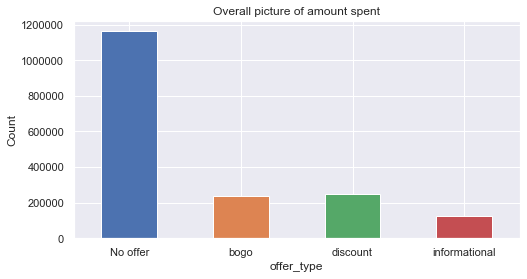

In [73]:
#let's verify amount spent by consumers within each offer type adding 'no offer' for transactions done independently from promos. 
trans_affect_tmp = trans_affect.copy ()
# replacing na values in offer type with No offer 
trans_affect_tmp["offer_type"].fillna('No offer', inplace = True) 

fig, ax = plt.subplots(figsize = (8,4))
trans_affect_tmp.groupby('offer_type')['amount']. sum ().plot(kind='bar', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_title('Overall picture of amount spent')
ax.set_ylabel('Count')
plt.show ()

In [74]:
trans_affect_tmp.groupby('offer_type')['amount']. sum ()

offer_type
No offer         1163305.98
bogo              236669.26
discount          249679.39
informational     125797.34
Name: amount, dtype: float64

In [75]:
trans_affect_tmp.groupby('offer_type')['amount']. sum ()/trans_affect_tmp['amount']. sum ()*100

offer_type
No offer         65.521681
bogo             13.330085
discount         14.062864
informational     7.085370
Name: amount, dtype: float64

**65%** of purchase inflows generated by transactions **not** related to any offer. Bogo and discount are giving relatively similar figures: 13.33 and 14.06% respectively. Informational is at most 7.08%. 


In [76]:
#plotting distribution of offers and the affected transactions  
y = df [df ['event'] =='offer received'].offer_type.value_counts().index.sort_values() #offer types

x1 = df [df ['event'] =='offer received'].offer_type.value_counts().sort_index()
x2= df [df ['event'] =='offer viewed'].offer_type.value_counts().sort_index()
x3= df [df ['event'] =='offer completed'].offer_type.value_counts().sort_index()
x4= trans_affect.offer_type.value_counts().sort_index()

off_rec = go.Bar(
    x=x1,
    y=y,
    text= x1,
    name = 'Offer received',
    textposition = 'auto',
    marker=dict(
        color='rgb(158,202,225)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
    opacity=0.6, orientation = 'h'
)
off_view = go.Bar(
    x=x2,
    y=y,
    text=x2,
    name = 'Offer viewed',
    textposition = 'auto',
    marker=dict(
        color='rgb(0,100,0)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
    opacity=0.6, orientation = 'h'
)
off_compl = go.Bar(
    x=x3,
    y=y,
    text=x3,
    name = 'Offer completed',
    textposition = 'auto',
    marker=dict(
        color='rgb(255,215,0)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
    opacity=0.6, orientation = 'h'
)
trans = go.Bar(
    x=x4,
    y=y,
    text=x4,
    name = 'Number of transactions affected by the offer',
    textposition = 'auto',
    marker=dict(
        color='rgb(178, 0, 0)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
    opacity=0.6, orientation = 'h'
)
data = [off_rec, off_view, off_compl, trans]
py.iplot(data, filename='grouped-bar-direct-labels')


**What kind of offers really excite people?**

In [77]:
#plotting distribution of offers and the affected transactions within offer subtype  

#adding new column 
trans_affect ['offer_subtype'] = trans_affect ['offer_id'].apply (define_subtype)

In [78]:
#plotting distribution of offer subtypes and the number of affected transactions  
y = df [df ['event'] =='offer received'].subtype.value_counts().index.sort_values()

x1 = df [df ['event'] =='offer received'].subtype.value_counts().sort_index ()
x2= df [df ['event'] =='offer viewed'].subtype.value_counts().sort_index ()
x3= df [df ['event'] =='offer completed'].subtype.value_counts().sort_index ()
x4= trans_affect.offer_subtype.value_counts().sort_index()

off_rec = go.Bar(
    x=x1,
    y=y,
    text= x1,
    name = 'Offer received',
    textposition = 'auto', 
    marker=dict(
        color='rgb(158,202,225)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
    opacity=0.6, orientation = 'h'
)
off_view = go.Bar(
    x=x2,
    y=y,
    text=x2,
    name = 'Offer viewed',
    textposition = 'auto',
    marker=dict(
        color='rgb(0,100,0)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
    opacity=0.6, orientation = 'h'
)
off_compl = go.Bar(
    x=x3,
    y=y,
    text=x3,
    name = 'Offer completed',
    textposition = 'auto',
    marker=dict(
        color='rgb(255,215,0)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
    opacity=0.6, orientation = 'h'
)
trans = go.Bar(
    x=x4,
    y=y,
    text=x4,
    name = 'Number of transactions affected by the offer',
    textposition = 'auto',
    marker=dict(
        color='rgb(178, 0, 0)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
    opacity=0.6, orientation = 'h'
)
data = [off_rec, off_view, off_compl, trans]
layout = go.Layout(
    autosize=True,
    yaxis=go.layout.YAxis(
        #title='Y-axis Title',
        #ticktext=['Very long label','long label','3','label'],
        #tickvals=[1, 2, 3, 4],
        #tickmode='array',
        automargin=True#,
        #titlefont=dict(size=30),
    )
    #width=900,
    #height=500,
    )

fig = go.Figure (data=data, layout=layout)
py.iplot(fig, filename='grouped-bar-direct-labels')

Diagrams reflect that for some offers number of transactions greater than number of offer completed events, this happens since customers have to perform several transactions so to achieve offer completeness. For the case when number of transactions is less than number of completed offers this happens as customers may receive several offers at the same time and both of them might be completed by the same transactions, however only one offer will be marked as the one affected them.  
In order to verify the first option let's take a look to the mean and median values of amount spent within offer subtypes. 

In [79]:
trans_affect [trans_affect ['offer_type'] != 'No offer'].groupby ('offer_subtype') ['amount'].mean ()

offer_subtype
bogo_5_10            20.547182
bogo_5_5             16.693620
bogo_7_10            19.303056
bogo_7_5             14.865343
discount_10_10       11.370450
discount_10_20       19.796339
discount_7_10        15.543094
discount_7_7         12.029116
informational_3_0    11.377109
informational_4_0    14.416144
Name: amount, dtype: float64

In [80]:
trans_affect [trans_affect ['offer_type'] != 'No offer'].groupby ('offer_subtype') ['amount'].median ()

offer_subtype
bogo_5_10            16.440
bogo_5_5             12.340
bogo_7_10            15.160
bogo_7_5             13.445
discount_10_10        6.350
discount_10_20       15.520
discount_7_10        12.930
discount_7_7          7.610
informational_3_0     7.490
informational_4_0    12.300
Name: amount, dtype: float64

Discount_10_10 (valid for 10 days, difficulty 10) got the biggest number of transactions performed. If we look at mean value it is more than required (10) to complete the transaction, however meadian value (6.35) explains that half of operations for such offer done for an amount that is less than 10, accordingly persons will have to proceed with more transactuions to compelete offer. 

On the contrast if we look at discount_7_10 (valid for 7 days, difficulty 10) we can see that number of transactions less than completed which can be explained by higher value for median and mean figures. 

**Please note** that the correlation between completed offers and the exact trasanctions influenced by the offer is not 100% certain, so difference between number of transactions and the number of completed offers can be partially explained by this ambiguity.   


**Verifying amount spent within each offer subtype**

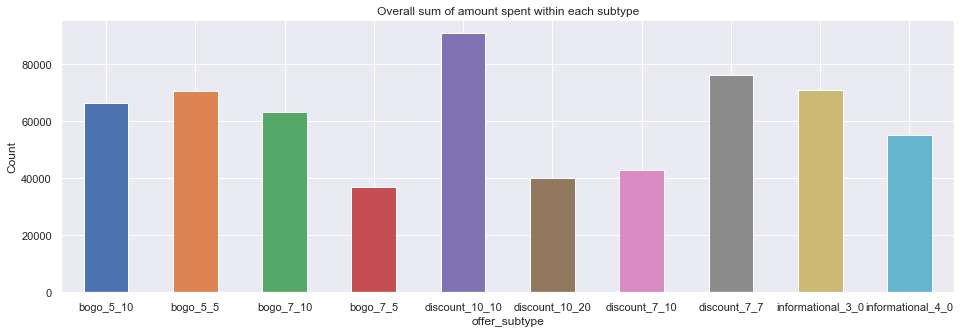

In [81]:
fig, ax = plt.subplots(figsize = (16,5))
trans_affect.groupby('offer_subtype')['amount']. sum ().plot(kind='bar', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_title('Overall sum of amount spent within each subtype')
ax.set_ylabel('Count')
plt.show ()

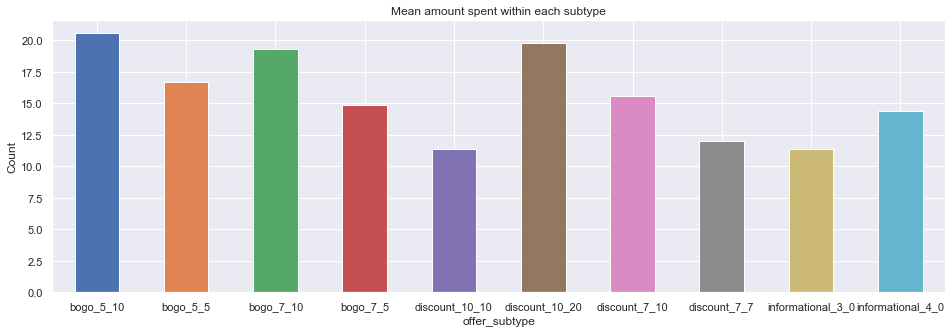

In [82]:
fig, ax = plt.subplots(figsize = (16,5))
trans_affect.groupby('offer_subtype')['amount']. mean ().plot(kind='bar', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_title('Mean amount spent within each subtype')
ax.set_ylabel('Count')
plt.show ()

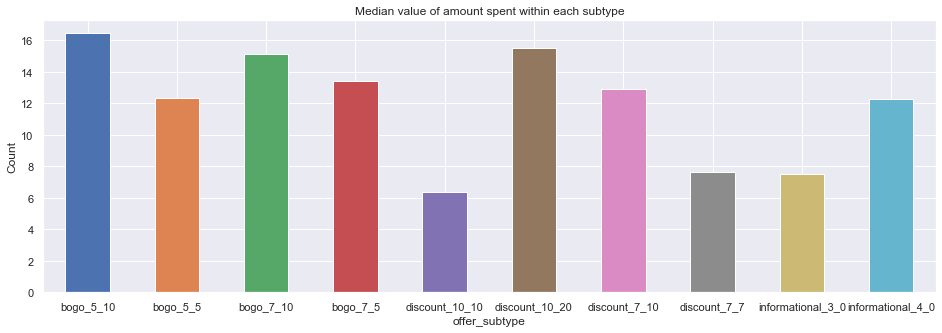

In [83]:
fig, ax = plt.subplots(figsize = (16,5))
trans_affect.groupby('offer_subtype')['amount']. median ().plot(kind='bar', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_title('Median value of amount spent within each subtype')
ax.set_ylabel('Count')
plt.show ()

<a id='offer_excite'> </a>
**What kind of offers really excite people?** 

We can call on offer 'rewarding' if it gives reward points to the customers upon completion.

From the above diagrams we can see that all offers subtypes were distributed almost equally, at the same time some of them being reviewed more frequently than others. We can consider that people are excited by a rewarding offer if it was reviewed and completed more frequently than others. 6 out of 10 offers have highest number of review rate, within them 2 rewarding offers are in the top - discount_10_10 and discount_7_7. They also got the highest number of influenced transactions performed.

We should also pay attention to the informational offers, especially to informational_3_0 as it got high number of affected transactions (6223) - pretty close to discount_7_7 (6335). 

These 3 offers are also champions in terms of overall sum of amount spent by customers, however for the mean and median values bogo_5_10, bogo_7_10 and discount 10_20 are leading. 

Discount_10_10 and discount_7_7 are two offers that really excite people.

**Number of customers never affected by provided offers**

In [84]:
completed_offers_ids = df [df ['event'] == 'offer completed']
received_offers_ids = df [df ['event'] == 'offer received']
viewed_offers_ids = df [df ['event'] == 'offer viewed']
persons_not_influenced= trans_affect ['person'].nunique () - trans_affect_tmp [trans_affect_tmp ["offer_type"] !='No offer'] ['person'].nunique ()

print ('Number of persons that received an offer at least once: ', received_offers_ids['person'].nunique ())
print ('Number of persons among clients that never received any offer: ', df ['person'].nunique()- received_offers_ids['person'].nunique ())
print ('Number of persons that viewed an offer at least once: ', viewed_offers_ids['person'].nunique ())
print ('Number of persons that completed an offer at least once: ', completed_offers_ids['person'].nunique ())
print ('Overall number of unique customers that made transactions: ', trans_affect ['person'].nunique ())
print ('Number of unique customers that are not influenced by offers: ', persons_not_influenced)
print ('Percentage of customers that were influenced by received offers: ', (completed_offers_ids['person'].nunique () -persons_not_influenced)/completed_offers_ids['person'].nunique ()*100)

Number of persons that received an offer at least once:  16994
Number of persons among clients that never received any offer:  6
Number of persons that viewed an offer at least once:  16834
Number of persons that completed an offer at least once:  12774
Overall number of unique customers that made transactions:  16578
Number of unique customers that are not influenced by offers:  3602
Percentage of customers that were influenced by received offers:  71.80209801158604


We can say that almost **72%** of customer that received offers positively reacted to them, from the other hand about **28%** were not affected although recieved offers. 

#### Closer look at the consumers never affected by the offers

In [85]:
#let's find a list of persons that never were affected by any offer although have done transactions
person_no_offer= np.array (trans_affect_tmp [trans_affect_tmp ["offer_type"] =='No offer'] ['person'].unique ())
person_with_offer = np.array (trans_affect_tmp [trans_affect_tmp ["offer_type"] !='No offer'] ['person'].unique ())

person_no_offer = np.setdiff1d (person_no_offer,person_with_offer)

In [86]:
#list of customers using and not using offers
customers_using_offers = profile [~profile ['id'].isin (person_no_offer)]
customers_not_using_offers = profile [profile ['id'].isin (person_no_offer)]

customers_using_offers_inc = profile_income [~profile_income ['id'].isin (person_no_offer)]
customers_not_using_offers_inc = profile_income [profile_income ['id'].isin (person_no_offer)]

D:\Users\Kusainov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:435: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



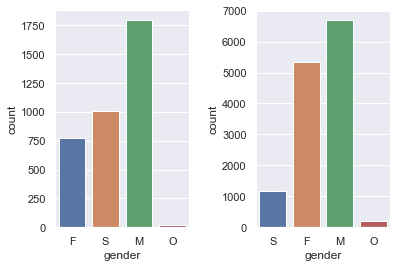

In [87]:
comparison_func (customers_not_using_offers, customers_using_offers, 'gender')


In [88]:
customers_not_using_offers ['gender'].describe()

count     3602
unique       4
top          M
freq      1794
Name: gender, dtype: object

In [89]:
customers_using_offers ['gender'].describe()

count     13398
unique        4
top           M
freq       6690
Name: gender, dtype: object

It appears that special group is presented in both datasets almost equally about 1000 persons, however within customers that do not use offers proportion of special group is around 28% while in second dataset the proportion is about 8%. 

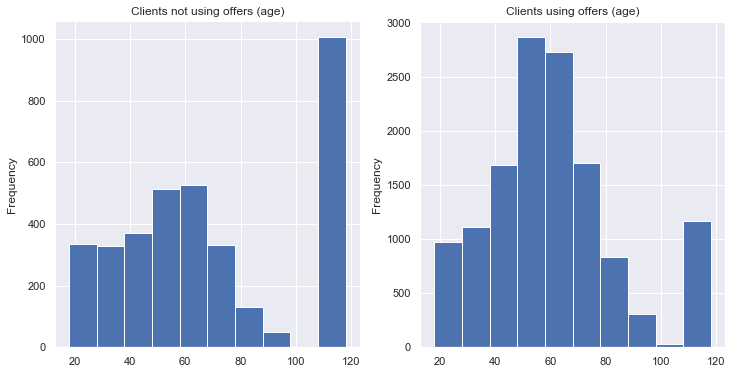

In [90]:
#plotting customers distribution by age
fig, axes = plt.subplots (nrows=1, ncols=2, figsize = (12,6))

customers_not_using_offers ['age'].plot (kind = 'hist',
                    title = 'Clients not using offers (age)',
                    #figsize = (6, 4.8),
                    ax = axes [0]
                      )
customers_using_offers ['age'].plot (kind = 'hist',
                    title = 'Clients using offers (age)',
                    #figsize = (6, 4.8), 
                    ax = axes [1]
                    )
#plt.subplots_adjust(wspace= 0.5)

In [91]:
print ('Mean of age for customers not using offers',customers_not_using_offers ['age'].mean ())
print ('Median of age for customers not using offers',customers_not_using_offers ['age'].median ())
print ('Mean of age for customers using offers',customers_using_offers ['age'].mean ())
print ('Median of age for customers using offers',customers_using_offers ['age'].median ())

Mean of age for customers not using offers 70.08967240421988
Median of age for customers not using offers 62.0
Mean of age for customers using offers 60.49940289595462
Median of age for customers using offers 58.0


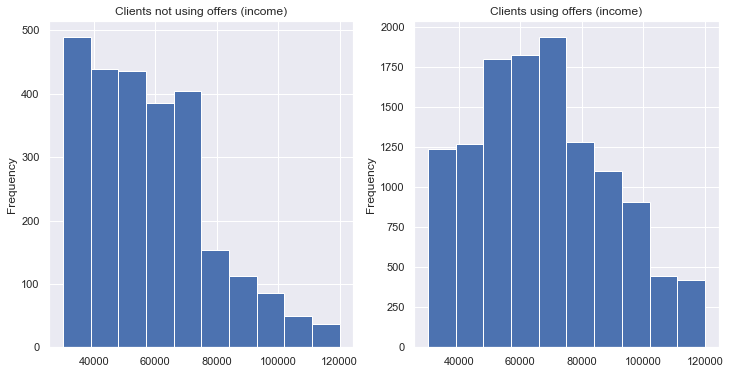

In [92]:
fig, axes = plt.subplots (nrows=1, ncols=2, figsize= (12,6))

#since income for special group is uncertain I have eliminated them from diagrams
customers_not_using_offers_inc ['income'].plot (kind = 'hist',
                    title = 'Clients not using offers (income)',
                    ax=axes [0]
                      )

customers_using_offers_inc ['income'].plot (kind = 'hist',
                    title = 'Clients using offers (income)',
                    ax=axes [1]
                      )


In [93]:
print ('Mean of income for customers not using offers: ',customers_not_using_offers ['income'].mean ())
print ('Median of income for customers not using offers: ',customers_not_using_offers ['income'].median ())
print ('Mean of income for customers using offers: ',customers_using_offers ['income'].mean ())
print ('Median of income for customers using offers: ',customers_using_offers ['income'].median ())

Mean of income for customers not using offers:  41617.43475846752
Median of income for customers not using offers:  45000.0
Mean of income for customers using offers:  61182.48992386924
Median of income for customers using offers:  62000.0


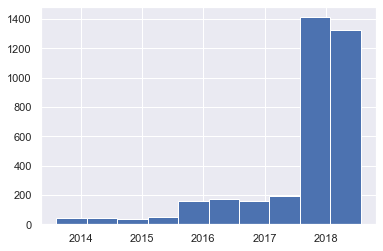

In [94]:
#plotting customers distribution by age
customers_not_using_offers ['became_member_on'].hist();

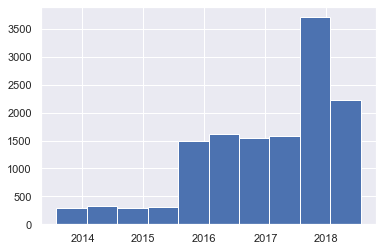

In [95]:
#plotting customers distribution by age
customers_using_offers ['became_member_on'].hist();

*****
Sum of money consumed by clients who do not respond completely to the offers and by those who respond

In [96]:
print ('Mean value of amount spent for people who do not respond to offers: ', trans_affect [trans_affect ['person'].isin (person_no_offer)]['amount'].mean ())
print ('Median value of amount spent for people who do not respond to offers: ', trans_affect [trans_affect ['person'].isin (person_no_offer)]['amount'].median ())
print ('Mean value of amount spent for people who respond to offers: ', trans_affect [~trans_affect ['person'].isin (person_no_offer)]['amount'].mean ())
print ('Median value of amount spent for people who respond to offers: ', trans_affect [~trans_affect ['person'].isin (person_no_offer)]['amount'].median ())

Mean value of amount spent for people who do not respond to offers:  5.81228928373128
Median value of amount spent for people who do not respond to offers:  2.63
Mean value of amount spent for people who respond to offers:  13.814546025813666
Median value of amount spent for people who respond to offers:  10.56


**Summary for the closer look at the consumers never affected by the offers**  
Within group of people that do not respond to the offers Special group plays significant role. It occupies second place with 28% for gender distribution while in the overall client base it is presented within 8% only. Similarly they are significantly presented within age distribution comparing to the general community. From the above I can conclude that this special group is overpresented among "not responsive" people. 

As for the general observations concerning 'not responsive' people, we can say that men ignoring offers more frequently than women, clients using offers generally younger and the income is higher. Majority of 'not responsive' customers registered in 2018. Positively responsive people tend to purchase for bigger amounts which probably explained by the their willing to complete offers.    

<a id='Model'> </a>
### Data preparation for FunkSVD, training, prediction and model finetuning.

#### Building base for FunkSVD

In [97]:
#using more convinient user_id for df. userid_dict contains mapping between original user values and new ids
userid_encoded, userid_dict = userid_mapper()
del df['person']
df['user_id'] = userid_encoded

#creating dictionary for all subtypes
subtype_dict = {'bogo_5_10':1, 'bogo_5_5':2, 'bogo_7_10':3, 'bogo_7_5':4, 'discount_10_10':5,
                 'discount_10_20':6, 'discount_7_10':7, 'discount_7_7':8, 'informational_3_0':9, 
                 'informational_4_0':10}
subt_dict_bogo_disc = {'bogo_5_10':1, 'bogo_5_5':2, 'bogo_7_10':3, 'bogo_7_5':4, 'discount_10_10':5,
                       'discount_10_20':6, 'discount_7_10':7, 'discount_7_7':8}
subt_dict_inform = {'informational_3_0':9, 
                    'informational_4_0':10}

#preparing ratings for all offers except informational. 
df_rate = offer_rate ()

#preparing rating for informational offers
df_rate_inform = offer_inform_rate ()

#concatenate all the dataframes
df_rate_joint = pd.concat ([df_rate, df_rate_inform], ignore_index = True)

# show header
df_rate_joint.head (n=5)

,user_id,rate,off_subtype_id
0,4,0,1
1,5,0,1
2,9,1,1
3,11,0,1
4,14,0,1


In [98]:
#let's take a look to user_item_matrix
user_item_matrix = df_rate_joint.groupby(['user_id', 'off_subtype_id'])['rate'].sum ().unstack()
user_item_matrix.head (n=5)

off_subtype_id,1,2,3,4,5,6,7,8,9,10
user_id,,,,,,,,,,
1,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN
2,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0
3,NaN,NaN,NaN,1.0,1.0,NaN,0.0,NaN,NaN,0.0
4,0.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0
5,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN


In [99]:
#proportion of missing values
user_item_matrix.isnull ().sum()/user_item_matrix.shape[0]

off_subtype_id
1     0.627516
2     0.631517
3     0.624926
4     0.626044
5     0.627398
6     0.624926
7     0.630164
8     0.627810
9     0.628104
10    0.627457
dtype: float64

We can see that each offer subtype contains around 63% missing values.

In [100]:
#Number of zeroes and ones in the matrix
for col in user_item_matrix.columns:
    print (user_item_matrix [col].value_counts()/user_item_matrix [col].notnull ().sum()*100)

0.0    54.423381
1.0    45.576619
Name: 1, dtype: float64
1.0    59.741297
0.0    40.258703
Name: 2, dtype: float64
0.0    50.156887
1.0    49.843113
Name: 3, dtype: float64
1.0    59.543666
0.0    40.456334
Name: 4, dtype: float64
1.0    71.541377
0.0    28.458623
Name: 5, dtype: float64
0.0    53.278946
1.0    46.721054
Name: 6, dtype: float64
1.0    55.369928
0.0    44.630072
Name: 7, dtype: float64
1.0    69.897233
0.0    30.102767
Name: 8, dtype: float64
1.0    50.332278
0.0    49.667722
Name: 9, dtype: float64
0.0    68.425209
1.0    31.574791
Name: 10, dtype: float64


From the above we can see that only for 3 offer subtypes proportion is about 70% to 30% while for the majority it is from 40/60 to 50/50. The classes are not highly imbalanced and the accuracy should be valid metric to use. 

In [101]:
#apply funkSVD on the whole dataset
user_mat, offer_mat = FunkSVD (np.matrix (user_item_matrix), latent_features=10, learning_rate=0.001, iters=50)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.345431
2 		 0.248962
3 		 0.245725
4 		 0.245110
5 		 0.244820
6 		 0.244571
7 		 0.244328
8 		 0.244086
9 		 0.243844
10 		 0.243603
11 		 0.243361
12 		 0.243120
13 		 0.242879
14 		 0.242639
15 		 0.242398
16 		 0.242158
17 		 0.241918
18 		 0.241678
19 		 0.241439
20 		 0.241199
21 		 0.240960
22 		 0.240721
23 		 0.240482
24 		 0.240244
25 		 0.240005
26 		 0.239767
27 		 0.239529
28 		 0.239291
29 		 0.239053
30 		 0.238816
31 		 0.238579
32 		 0.238342
33 		 0.238105
34 		 0.237868
35 		 0.237631
36 		 0.237395
37 		 0.237159
38 		 0.236923
39 		 0.236687
40 		 0.236452
41 		 0.236216
42 		 0.235981
43 		 0.235746
44 		 0.235511
45 		 0.235276
46 		 0.235042
47 		 0.234807
48 		 0.234573
49 		 0.234339
50 		 0.234105


In [102]:
#looking at prediction and original matrix
print (np.abs (np.round (np.dot(user_mat, offer_mat))))
np.matrix (user_item_matrix)

[[0. 1. 0. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 0. ... 1. 0. 0.]
 ...
 [0. 1. 0. ... 1. 0. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 0.]]


matrix([[nan,  1.,  1., ..., nan,  1., nan],
        [nan, nan, nan, ..., nan,  0.,  0.],
        [nan, nan, nan, ..., nan, nan,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [ 0., nan, nan, ..., nan, nan, nan],
        [ 0., nan, nan, ..., nan, nan, nan]])

**But how are we doing? Is the prediction good enough?**  
In order to validate results we can split rates into train and test sets. Train model on the train set and verify how well it is doing on the test set, comparing to a naive predictor. We can assume naively that all offers will be completed/used by all customers. It should be kept in mind that we can verify predictions only for customers and offer subtypes that presented in both datasets.

In [103]:
#preparing train and test user_item_matrix
train_matrix, test_matrix = user_item_train_test_split (df_rate_joint) 
print ('Number of common customers in both train and test sets: {}'. format (len (train_matrix.index.intersection (test_matrix.index))))
print ('Number of common offer subtypes in both train and test sets: {}'. format (len (train_matrix.columns.intersection (test_matrix.columns))))
print ("Number of customers for whom we are not able to make predictions due to cold start problem: ", len (test_matrix.index) - len (train_matrix.index.intersection (test_matrix.index)))

Number of common customers in both train and test sets: 5456
Number of common offer subtypes in both train and test sets: 10
Number of customers for whom we are not able to make predictions due to cold start problem:  45


In [104]:
#take a look to the result
display (train_matrix.head (n=10))
display (test_matrix.head (n=10))

off_subtype_id,1,2,3,4,5,6,7,8,9,10
user_id,,,,,,,,,,
1,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
3,NaN,NaN,NaN,1.0,1.0,NaN,0.0,NaN,NaN,0.0
4,0.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN
5,0.0,NaN,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN
6,NaN,1.0,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN
7,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN
8,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,0.0
9,1.0,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN


off_subtype_id,1,2,3,4,5,6,7,8,9,10
user_id,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
5,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
9,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
19,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
20,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
#checking proportion of missing values in both sets
print (train_matrix.isnull().sum()/train_matrix.shape[0])
print (test_matrix.isnull().sum()/test_matrix.shape[0])


off_subtype_id
1     0.665113
2     0.668299
3     0.660688
4     0.664051
5     0.663815
6     0.660629
7     0.665644
8     0.664051
9     0.663697
10    0.663402
dtype: float64
off_subtype_id
1     0.881113
2     0.883658
3     0.886748
4     0.879840
5     0.884748
6     0.886930
7     0.887657
8     0.885294
9     0.887293
10    0.886203
dtype: float64


We can see that number of missing values for each subtype increased from 63% to 66% for train set and to 88% for test set. 

#### Fitting model to the train dataset

In [106]:
#fit to train 
user_mat_train, offer_mat_train = FunkSVD (np.matrix (train_matrix), latent_features=5, learning_rate=0.001, iters=20)
train_predict_np= np.abs(np.round (np.dot(user_mat_train, offer_mat_train)))

#checking predicted values in each column, it should be filled only with zeroes and ones
predict_train_matrix = pd.DataFrame (train_predict_np, index = train_matrix.index, columns = train_matrix.columns)
for j in predict_train_matrix.columns:
    print (predict_train_matrix[j].value_counts())

#validation results on train and test sets    
validation_func (train_matrix, predict_train_matrix, is_train=True)
validation_func (test_matrix, predict_train_matrix)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.292109
2 		 0.256978
3 		 0.254635
4 		 0.253903
5 		 0.253411
6 		 0.252956
7 		 0.252507
8 		 0.252059
9 		 0.251612
10 		 0.251165
11 		 0.250720
12 		 0.250275
13 		 0.249831
14 		 0.249388
15 		 0.248945
16 		 0.248504
17 		 0.248063
18 		 0.247623
19 		 0.247184
20 		 0.246746
0.0    12367
1.0     4582
Name: 1, dtype: int64
1.0    10274
0.0     6675
Name: 2, dtype: int64
0.0    9483
1.0    7466
Name: 3, dtype: int64
1.0    11135
0.0     5814
Name: 4, dtype: int64
1.0    14066
0.0     2883
Name: 5, dtype: int64
0.0    9363
1.0    7586
Name: 6, dtype: int64
1.0    8546
0.0    8403
Name: 7, dtype: int64
1.0    13659
0.0     3290
Name: 8, dtype: int64
0.0    10593
1.0     6356
Name: 9, dtype: int64
0.0    16716
1.0      233
Name: 10, dtype: int64


MSE on the train set is:  0.4288523323794308
RMSE on the train set is:  0.6548681793914183
Accuracy on the train set is:  0.5711476676205691




MSE on the test set is:  0.434

Now let's compare above results with the Naive predictor.

In [107]:
#Comparing to naive predictor model
base_predict = predict_train_matrix.copy ()

#we consider that all offers would be used by customers
for j in base_predict.columns:
    base_predict[j] = 1.0
    
#accuraccy and MSE, RMSE for naive predictor model
print ('Naive model prediction metric:')
validation_func (test_matrix, base_predict)

Naive model prediction metric:


MSE on the test set is:  0.4621583188497393
RMSE on the test set is:  0.679822270045443
Accuracy on the test set is:  0.5378416811502607




*****
As it can be seen our FunkSVD model is not doing very well as the accuracy difference on the test set between the model and Naive predictor is only 3%.  

**Can this result be improved?**  
We can use custom gridsearch_funkSVD function that will verify how well the model doing with all possible parameters.  
Note: column "overfitting" is filled with "Yes" whenever prediction is giving values besides 0s and 1s. The same fact is justified by the performance of the model on the train set.

In [108]:
#now let's fine-tune model using different number of latent features, learning rate and number of iterations.
params = {"latent_feat": [5, 10, 15],
          "num_iter": [50, 100, 150],
          "learning_rate": [0.001, 0.005, 0.01]
          }
gridsearch_funkSVD (params)

,index,num_latent_feat,learning_rate,number_of_iter,mse_on_train,acc_on_train,mse_on_test,acc_on_test,overfitting
0,26,5,0.001,50,0.395793,0.604207,0.415073,0.584927,No
1,25,5,0.005,50,0.234555,0.765445,0.327540,0.672460,No
2,24,5,0.010,50,0.153514,0.846486,0.299573,0.700427,No
3,23,5,0.001,100,0.343071,0.656929,0.387897,0.612103,No
4,22,5,0.005,100,0.144227,0.855773,0.290725,0.709275,No
5,21,5,0.010,100,0.050282,0.949718,0.300679,0.701849,Yes
6,20,5,0.001,150,0.297108,0.702892,0.367357,0.632643,No
7,19,5,0.005,150,0.083393,0.916607,0.289777,0.711171,Yes
8,18,5,0.010,150,0.014607,0.985393,0.341760,0.668352,Yes
9,17,10,0.001,50,0.403237,0.596763,0.421394,0.578606,No


#### Observations: 
We can see that the more number of latent features, iterations and the larger learning we use then accordingly the more chance for the model to overfit on the train set and and on contrary lower number of iterations, latent features and learning rate makes performance of the model poorer on the test set.  
So there should a trade off between parameters and performance. 

From the above table the best parameters are:number of latent features =5, learning rate=0.005, number of iterations=100.  
These parameters are giving optimized model.

|     Metric     | Naive Model       |Unoptimized Model  | Optimized Model | 
| :------------: | :---------------: | :-------------:   | :-------------: | 
| Accuracy Score | 0.5378            |0.5659             | 0.7093          | 
| MSE            | 0.4621            |0.4340             | 0.2907          | 

Now that we have understanding about the best parameters, let's apply FunkSVD using them on the whole dataset 

In [109]:
#apply model using best parameters
user_mat, offer_mat = FunkSVD (np.matrix (user_item_matrix), latent_features=5, learning_rate=0.005, iters=100, verbose=False)

prediction= np.abs(np.round (np.dot(user_mat, offer_mat)))
predict_matrix = pd.DataFrame (prediction, index = user_item_matrix.index, columns = user_item_matrix.columns)

#inspect some user_id / offer comparing to the actual values. 
display (user_item_matrix.head (n=10))
display (predict_matrix.head (n=10))

off_subtype_id,1,2,3,4,5,6,7,8,9,10
user_id,,,,,,,,,,
1,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN
2,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0
3,NaN,NaN,NaN,1.0,1.0,NaN,0.0,NaN,NaN,0.0
4,0.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0
5,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN
6,NaN,1.0,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN
7,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN
8,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,0.0
9,1.0,1.0,1.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN


off_subtype_id,1,2,3,4,5,6,7,8,9,10
user_id,,,,,,,,,,
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
9,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


Verify whether the model is overfitting.

In [110]:
#verify if any overfitting presented in the predicted matrix
k=False
for j in predict_matrix.columns:
    if predict_matrix[j].nunique()>2:
        k=True
        print ('Model is overfitting')
        break
if k==False:
    print ('Model is NOT overfitting')


Model is NOT overfitting


*****
Another kind of inspection we can perform comparing proportion of posivite and negative reactions to the offer subtypes in the original dataset and the predicted. Presumably the algorithms that produced the dataset are designed to keep similar proportion of positive and negative reactions for all customers and offers. If this is true then we should expect the model to keep the proportions for all customers within offer subtypes similar to original dataset. Let's verify if our model is doing that. 

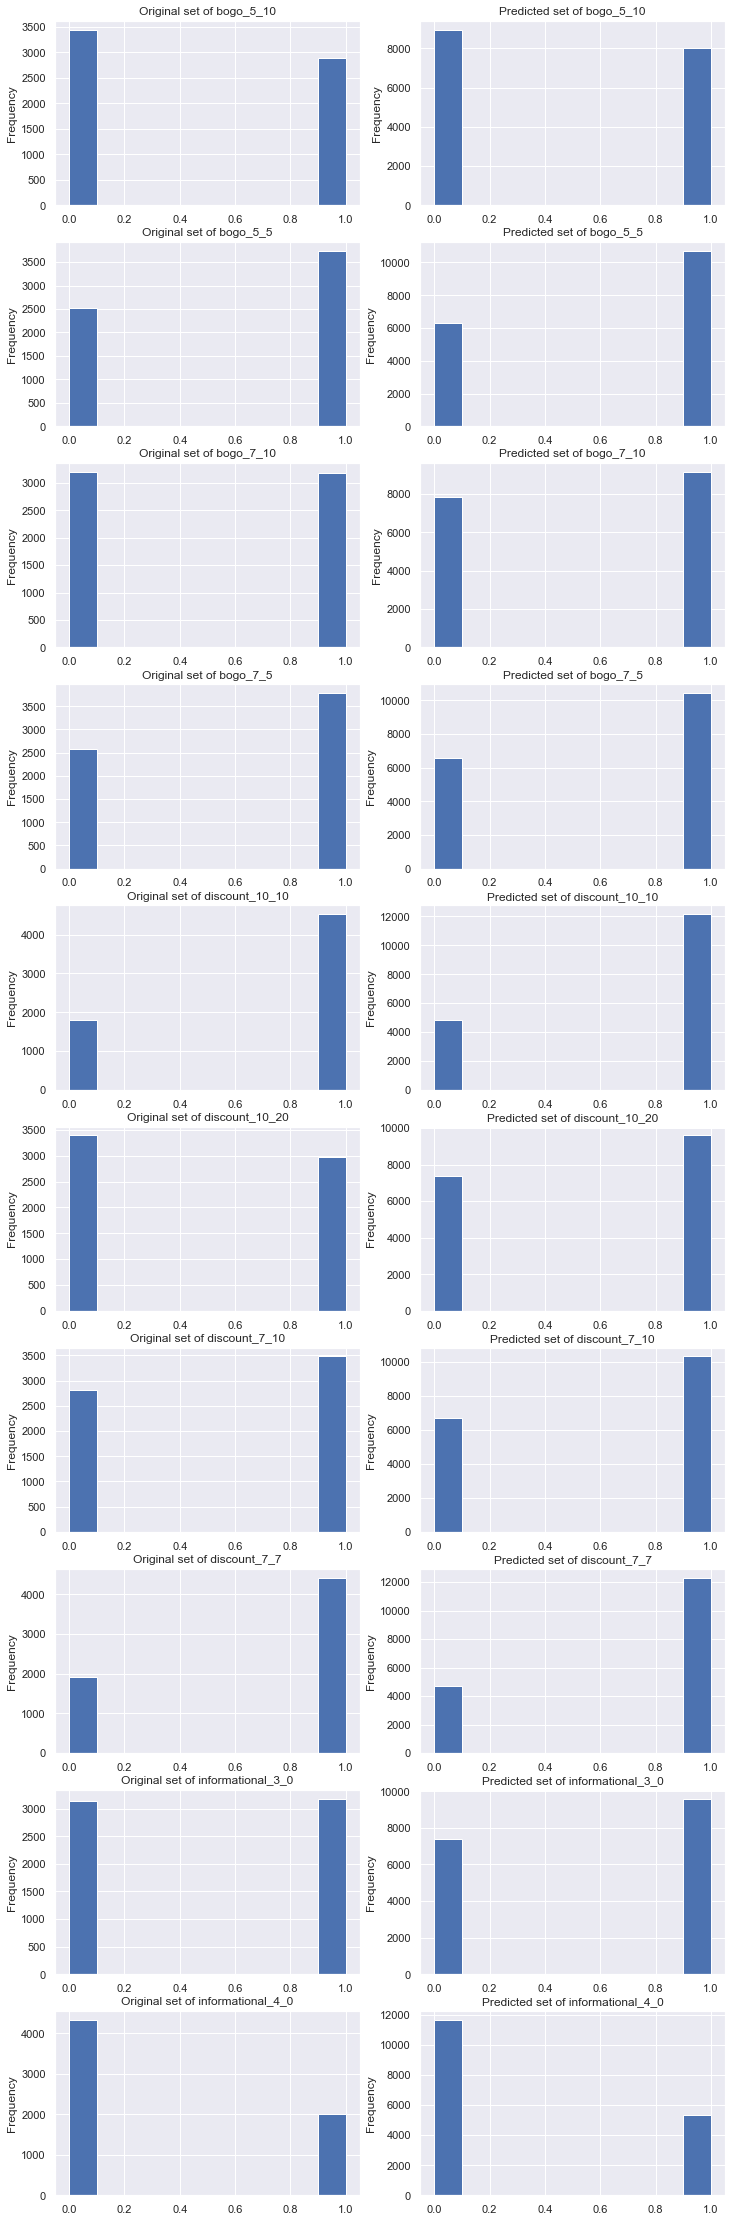

In [111]:
#comparing proportion of positive and negative reaction to the offers in original dataset and predicted
fig, axes = plt.subplots (nrows=10, ncols=2, figsize = (12,40))

for i,j in subtype_dict.items():
    user_item_matrix [j].plot (kind = 'hist',
                    title = 'Original set of '+str(i),
                    ax = axes [j-1,0]
                      )
    predict_matrix [j].plot (kind = 'hist',
                    title = 'Predicted set of '+str(i),
                    ax = axes [j-1,1]
                    )
    
plt.show()

From the above we can see that for the majority of offer subtypes the proportions are similar except for informational_3_0, discount_10_20. The ground truth can be found only when we observe simulation of the algorithms for the all customers, so that we have user_item_matrix without missing values. 

<a id='conclusion'> </a>
### Conclusion



Throughout the notebook I have analyzed Starbucks given data, applied data cleaning, transformation and visualization. 

**65.53%** of purchase inflows generated by transactions not related to any offer. Discount and bogo are giving relatively similar to each other figures: 14.06% and 13.33% respectively. Informational is at most 7.08%. Majority of the revenue generated by transactions not influenced to offers.

These **35%** of cash inflows influenced by offers are generated by almost **72%** of customer that received offers at least once. Within given consumer population  about **28%** were not affected at all although recieved at least one offer during the experiment. 

It was found that discount offers with difficulty 7, 10 and duration 7 and 10 respectively are the offers that really excite people. From informational offers, an offer with 3 days durations is also got high influence rate to the consumers. These 3 offers are leading in terms of overall sum of amount spent by the customers.

As for the general observations concerning 'not responsive' people, we can say that men ignoring offers more frequently than women, clients not using offers generally older and the income is lower comparing to responsive. Majority of 'not responsive' customers registered in 2018. Positively responsive people tend to purchase for bigger amounts which probably explained by the their willing to complete offers. Moreover I have identified special group of people that is heavily presented among consumers ignoring offers.

Based on the transformed transactional information I have formed user-item-matrix that reflects positive or negative (ignore) reaction of customers to the received offers. 

Basic form of FunkSVD without regularization was selected to fulfill missing values (rates) in user-item-matrix as not all customers recieved all of possible offers. In order to assess how well the model is doing I have splitted the data into tran and test sets. As it was expected the model is doing better than a naive prediction (sending offers to all customers as if all customers are happy to receive and use offers) on the test set. What we should keep in mind is that for 45 customers we could not make predictions due to cold start problem as they were not presented in both sets simultaneously.  

I could not achieve accuracy more than 0.7093 as the more the model is trained on the trainset the more it is overfitting. So there was a trade off between training model on the train set and the prediction power on test set. Although 0.7093 does not look very bad, we should think over possible further steps.  

**What else can be done? Possible further analysis and improvement**

1.  Performance can be compared with supervised learning algorithms that will receive as input customer data and will predict whether consumer positively responds to an offer or not. 
2.  Special group of people can be eliminated from the dataset and the model performance can be compared to the previously achieved. Probably the special group is adding variance to the data and accordingly the model cannot generalize better. 
3. As an alternative to the offline approach we used here, we could do an online approach where we run an experiment to determine the impacts of implementing one or more recommendation systems into our user base (one can be based on FunkSVD and the second one based on supervised learning algorithm for example). A simple experiment for this situation might be to randomly assign users to a control group that receives additonal offers they never seen. Then we capture reaction to them and compare it with the predictions of the selected algorithms and measure performance. 



****
**Thank you for reading this.** 